# Library

In [ ]:
!pip install Sastrawi

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('stopwords')

## Importing Data  

In [3]:
data = pd.read_csv('data.csv', delimiter=',')
print("Banyak Data:", len(data))
print(data.info())
print(data.keys())
print(data.head())

Banyak Data: 6982
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982 entries, 0 to 6981
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    6982 non-null   object 
 1   label   6980 non-null   float64
dtypes: float64(1), object(1)
memory usage: 109.2+ KB
None
Index(['text', 'label'], dtype='object')
                                                text  label
0                                 gelisah bgt astaga    1.0
1  tidur susah, pikiran kacau, hati gelisah. Semu...    1.0
2  Serba salah, mundur sayang, maju ragu. Diem di...    1.0
3  Udah ngalihin fokus ke yang lain tapi tetep cemas    1.0
4  Resah dan gelisah deh mimin, dah sebulan lewat...    1.0


## Data Cleaning

In [6]:
# Membuat stemmer dan stopword remover
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# Stopword Bahasa Indonesia dari nltk
stop_words = set(stopwords.words('indonesian'))

# Atau menggunakan Sastrawi
factory = StopWordRemoverFactory()
stop_words_sastrawi = set(factory.get_stop_words())

# Gabungkan stopword dari kedua sumber jika diperlukan
stop_words = stop_words.union(stop_words_sastrawi)

In [8]:
data.head()

,text,label
0,gelisah bgt astaga,1.0
1,"tidur susah, pikiran kacau, hati gelisah. Semu...",1.0
2,"Serba salah, mundur sayang, maju ragu. Diem di...",1.0
3,Udah ngalihin fokus ke yang lain tapi tetep cemas,1.0
4,"Resah dan gelisah deh mimin, dah sebulan lewat...",1.0


In [9]:
#cleaning tweet using regex
def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub(r'^RT\s+', '', temp, flags=re.IGNORECASE).strip()
    temp = re.sub("@\S+","", temp)      # Remove mentions
    temp = re.sub("#[A-Za-z0-9_]+","", temp)      # Remove hashtags
    temp = re.sub(r"https\S+","", temp)           # Remove URLs
    temp = re.sub('[()!?]', '', temp)             # Remove specific punctuations
    temp = re.sub("\[.*?\]","", temp)             # Remove text inside square brackets
    temp = re.sub("[^a-z0-9\s]", "", temp)        # Remove non-alphanumeric characters (preserve spaces)
    temp = re.sub(r'[0-9]', '', temp)             # Remove digits
    temp = re.sub('\s+', ' ', temp).strip()       # Replace multiple spaces with a single space and strip leading/trailing spaces
     # Remove stopwords
    temp = ' '.join([word for word in temp.split() if word not in stop_words])
    temp = stemmer.stem(temp)
    return temp

data['clean'] = data['text'].apply(lambda x: clean_tweet(x))

KeyboardInterrupt: 

In [ ]:
spell_lex = pd.read_csv("colloquial-indonesian-lexicon.csv")


In [ ]:
spell_lex.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,"Selamat ulang tahun kakak tulus semoga panjang umur kakak,sehat selalu juga,murah rezeki ya kakak dan jangan sombong kalo sukses di karirnya aminn @tulusm",elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @tulusm,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @tulusm,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [ ]:
# Ensure 'slang' and 'formal' columns are in the lexicon
if 'slang' not in spell_lex.columns or 'formal' not in spell_lex.columns:
    raise ValueError("The CSV file must contain 'slang' and 'formal' columns")

# Define the function to replace slang terms
def replace_internet_slang(text_series, slang, replacement, ignore_case=True):
    if ignore_case:
        flags = re.IGNORECASE
    else:
        flags = 0

    # Ensure the replacement is applied element-wise if text_series is a pandas Series
    def replace_text(text):
        for s, r in zip(slang, replacement):
            text = re.sub(s, r, text, flags=flags)
        return text

    return text_series.apply(replace_text)

# Prepare the regex patterns for slang terms
slang_patterns = ["\\b" + re.escape(s) + "\\b" for s in spell_lex['slang']]


In [ ]:
data['text'] = replace_internet_slang(
    data['clean'],
    slang=slang_patterns,
    replacement=spell_lex['formal'],
    ignore_case=True
)

In [ ]:
data = data.drop(columns=['text'])

In [ ]:
data.dropna(subset=['label',  'clean'], inplace=True)

In [ ]:
print(data.info())
print(data.keys())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 6980 entries, 0 to 6981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   teks    6980 non-null   object 
 1   label   6980 non-null   float64
 2   clean   6980 non-null   object 
dtypes: float64(1), object(2)
memory usage: 218.1+ KB
None
Index(['teks', 'label', 'clean'], dtype='object')
                                                    teks  label  \
0                                                  ampun    1.0   
1         susah tidur pikir bingung hati gelisah selaras    1.0   
2  salah mundur sayang maju ragu tinggal gelisah gelisah    1.0   
3                                    alih fokus khawatir    1.0   
4                           resah resah bulan nak maksud    1.0   

                                                   clean  
0                                                  ampun  
1         susah tidur pikir bingung hati gelisah selaras  
2  salah mundur sayang ma

In [ ]:
data['tokens'] = data['clean'].apply(word_tokenize)

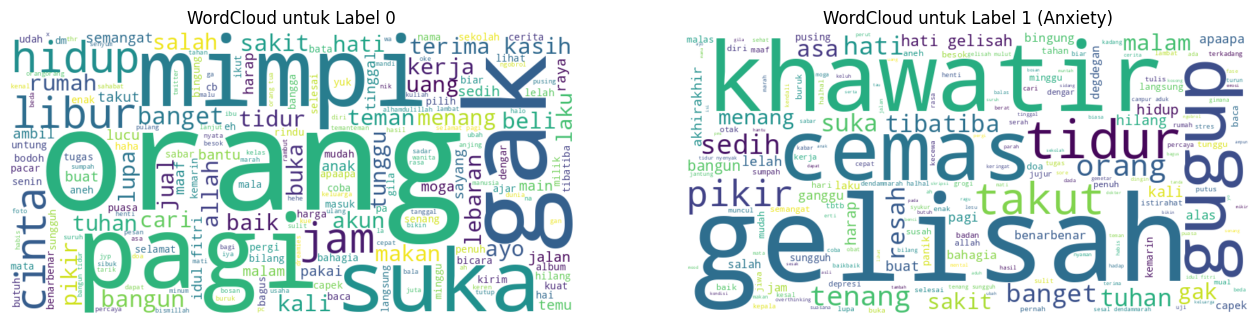

In [ ]:
label_0_data = data[data['label'] == 0]['clean']
label_1_data = data[data['label'] == 1]['clean']

# Gabungkan teks untuk setiap label menjadi satu string besar
text_label_0 = " ".join(label_0_data)
text_label_1 = " ".join(label_1_data)

# Buat WordCloud untuk setiap label
wordcloud_label_0 = WordCloud(width=800, height=400, background_color='white').generate(text_label_0)
wordcloud_label_1 = WordCloud(width=800, height=400, background_color='white').generate(text_label_1)

# Tampilkan WordCloud
plt.figure(figsize=(16, 8))

# WordCloud untuk label 0
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_label_0, interpolation='bilinear')
plt.title('WordCloud untuk Label 0')
plt.axis('off')

# WordCloud untuk label 1
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_label_1, interpolation='bilinear')
plt.title('WordCloud untuk Label 1 (Anxiety)')
plt.axis('off')

plt.show()

## SMOTE

In [ ]:
# Selecting the features and target
X = data['clean'].fillna('')
y = data['label']

# Using TF-IDF for vectorizing the text
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42, stratify=y)

# Initializing SMOTE
smote = SMOTE(random_state=42)

# Applying SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Displaying label distribution before and after SMOTE
print("Distribusi label sebelum SMOTE:\n", y_train.value_counts())

# Displaying label distribution before and after SMOTE
print("Distribusi label sebelum SMOTE:\n", y_test.value_counts())

Distribusi label sebelum SMOTE:
 label
0.0    4998
1.0     586
Name: count, dtype: int64
Distribusi label sebelum SMOTE:
 label
0.0    1249
1.0     147
Name: count, dtype: int64


In [ ]:
# Inverse transform the TF-IDF vectors to get the original text back
# Note: This may not give the exact original text due to the nature of TF-IDF transformation
#       But it will give a close approximation.
texts_res = vectorizer.inverse_transform(X_train_res)

# Join the words back to form the text
original_texts_res = [' '.join(text) for text in texts_res]

# Convert to DataFrame
train_data = pd.DataFrame({
    'clean': original_texts_res,
    'label': y_train_res
})


In [ ]:
# Inverse transform the TF-IDF vectors to get the original text back
# Note: This may not give the exact original text due to the nature of TF-IDF transformation
#       But it will give a close approximation.
texts_res = vectorizer.inverse_transform(X_test)

# Join the words back to form the text
original_texts_res = [' '.join(text) for text in texts_res]

# Convert to DataFrame
test_data = pd.DataFrame({
    'clean': original_texts_res,
    'label': y_test
})


# Modelling

In [12]:
data.head()

,clean,label
0,wibawa puji hadap manusia suka allah,0.0
1,apaapaanhadeh waswas ngerjain tibatiba enggak ...,1.0
2,kemane sadar nya,0.0
3,nyerah benar capek banget,0.0
4,pov istri orang,0.0


In [15]:
data.dropna(subset=['clean', 'label'], inplace=True)

In [18]:
vocab_size = 1000
embedding_dim = 16
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = .8

# Mengumpulkan kalimat dan label
sentences = data['clean'].tolist()
labels = data['label'].tolist()

# Memisahkan data menjadi training dan validation set
training_size = int(len(sentences) * training_portion)
training_sentences = sentences[: training_size]
training_labels = labels[: training_size]

validation_sentences = sentences[training_size:]
validation_labels = labels[training_size:]

# Tokenizing the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert labels to numerical values
training_labels = np.array(training_labels)
validation_labels = np.array(validation_labels)


In [19]:
# Membuat model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training model
history = model.fit(
    training_padded,
    training_labels,
    epochs=10,
    batch_size=16,
    validation_data=(validation_padded, validation_labels),
    verbose=2
)

Epoch 1/10
495/495 - 2s - loss: 0.5215 - accuracy: 0.7414 - val_loss: 0.3574 - val_accuracy: 0.8949 - 2s/epoch - 4ms/step
Epoch 2/10
495/495 - 1s - loss: 0.1576 - accuracy: 0.9673 - val_loss: 0.0875 - val_accuracy: 0.9808 - 970ms/epoch - 2ms/step
Epoch 3/10
495/495 - 1s - loss: 0.0478 - accuracy: 0.9933 - val_loss: 0.0152 - val_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 4/10
495/495 - 2s - loss: 0.0215 - accuracy: 0.9970 - val_loss: 0.0094 - val_accuracy: 1.0000 - 2s/epoch - 3ms/step
Epoch 5/10
495/495 - 2s - loss: 0.0143 - accuracy: 0.9976 - val_loss: 0.0057 - val_accuracy: 1.0000 - 2s/epoch - 3ms/step
Epoch 6/10
495/495 - 1s - loss: 0.0113 - accuracy: 0.9977 - val_loss: 0.0038 - val_accuracy: 1.0000 - 1s/epoch - 3ms/step
Epoch 7/10
495/495 - 1s - loss: 0.0099 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 1.0000 - 948ms/epoch - 2ms/step
Epoch 8/10
495/495 - 1s - loss: 0.0086 - accuracy: 0.9980 - val_loss: 2.9276e-04 - val_accuracy: 1.0000 - 1s/epoch - 2ms/step
Epoch 9/10
495

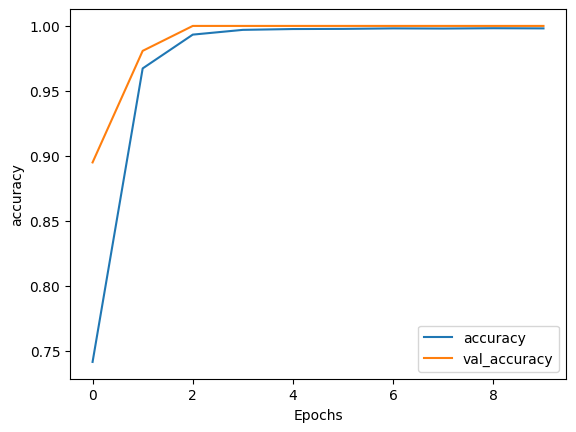

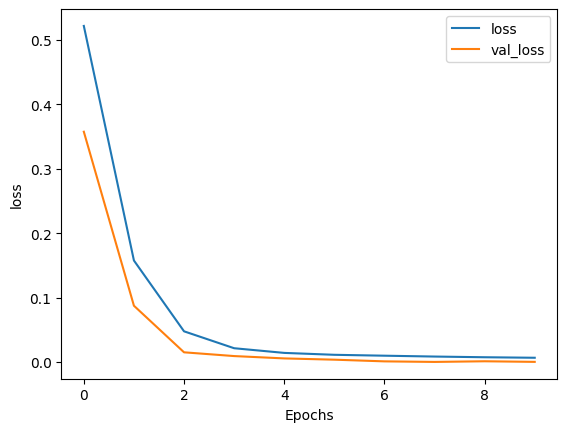

In [21]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

# Plot accuracy and loss
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [22]:
model.save("modelEquilibrare.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengkonversi model menjadi format TensorFlow Lite
tflite_model = converter.convert()

# Menyimpan model TensorFlow Lite ke file .tflite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)